# Analyzing Football Player Scores

We live in an era where data has become largely available for almost any field of study. And sports is no different. Every action a player makes is measured, and made available through extensive datasets. With all this data available, what could we use it for?\
We will be looking at a set of stats for Football players in Spain and France, two of the world's most important leagues. By segmenting players into clusters, we start by finding groups with similarities. The clusters might resemble the positions, Forward, Midfielder and Defender, but not all players end up in the same cluster as its position. Are some midfielders playing more like a defender? And who are the players that are most different from all the groups?\
The data can also be useful to discover what makes each player unique. Which are the aspects in which a player stands out from the rest?\
Data doesn't replace watching the games to learn about the sport, but it is a great complement. It allows us to let go of biases, and also put into numbers intuitions one might have. Is Messi in 2022 so different from the rest? According to this data, yes, he is the player with a the most different playing style.

![SegmentLocal](Images/messi-psg.jpeg "segment")

## Preparing Data

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import plotly.express as px

from requests import get as get
from requests import post as post
import json
import bcrypt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

### API Authentication

Get player stats from Sorare, a Fantasy Football website that provides stats and scores for each player in major leagues through a GraphQL API. 

Authenticate

In [4]:
from password import password
email = "maite.marzoratti@gmail.com"

r = get(f'https://api.sorare.com/api/v1/users/{email}')
response = json.loads(r.content)
cookies={"_sorare_session_id":r.cookies['_sorare_session_id']}
# get salt and hash with password
salt = response['salt'].encode('utf8')
pwrd = password.encode('utf8')
hashed = bcrypt.hashpw(pwrd, salt).decode('utf8')
csrf = r.headers["CSRF-TOKEN"]

headers = {
    "x-csrf-token": csrf
}

# login
url = 'https://api.sorare.com/graphql'
login_query = """
mutation SignInMutation($input: signInInput!) {
  signIn(input: $input) {
    currentUser {
      slug
      __typename
    }
    otpSessionChallenge
    errors {
      path
      message
      __typename
    }
    __typename
  }
}
"""

variables = {
  "input": {
    "email": email,
    "password": hashed
  }
}

p = post(url, json={'query': login_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)


### Sorare API Query

Query to get all clubs from Spains's La Liga

In [6]:
clubs_query="""
query{
    competition(slug:"primera-division-es") {
    clubs {
      nodes {
        slug
      }
    }
  }
}

"""

clubs=post(url, json={'query': clubs_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)

slugs=pd.json_normalize(clubs.json()['data'])
slugs=slugs.loc[0].iloc[0]

club_slugs=[]
for i in slugs:
    club_slugs.append(i['slug'])

And France's Ligue 1

In [7]:
clubs_query="""query{
    competition(slug:"ligue-1-fr") {
    clubs {
      nodes {
        slug
      }
    }
  }
}"""

clubs=post(url, json={'query': clubs_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)
slugs=pd.json_normalize(clubs.json()['data'])
slugs=slugs.loc[0].iloc[0]

for i in slugs:
    club_slugs.append(i['slug'])

In [8]:
len(club_slugs)

40

Query to get all players from clubs list

In [9]:
i=0

players_query="""
query playerQuery($club:String!){
  club(slug:$club) {
        name
        slug
        activePlayers {
          nodes {
            displayName
            slug
            status {
              lastFiveSo5Appearances
              lastFiveSo5AverageScore
              lastFifteenSo5Appearances
              lastFifteenSo5AverageScore
              playingStatus
            }
            lastClub {
              name
              activeCompetitions {
                name
              }
            }
            allSo5Scores (first:5) {
              nodes {
                position
                score
                detailedScore {
                  category
                  points
                  stat
                  statValue
                  totalScore
                }
              }
            }
       }
     }
   }

 }"""




club_player_data=pd.DataFrame()
for i in range(0,len(club_slugs)):
    variables = {
        "club":club_slugs[i]
        }
    active_players_r=post(url, json={'query': players_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)

    club_player_data=club_player_data.append(pd.json_normalize(active_players_r.json()['data']))


club_df=club_player_data.reset_index(drop=True)
club_df.shape

### Response Clean Up

Create a dataframe with the data provided in json format by the API

In [13]:
club_df.head()

,club.name,club.slug,club.activePlayers.nodes
0,CA Osasuna,osasuna-pamplona-irunea,"[{'displayName': 'Arrasate', 'slug': 'jagoba-a..."
1,Real Madrid CF,real-madrid-madrid,"[{'displayName': 'Rodrygo', 'slug': 'rodrygo-s..."
2,Granada CF,granada-granada,"[{'displayName': 'Luis Suárez', 'slug': 'luis-..."
3,Cádiz CF,cadiz-cadiz,"[{'displayName': 'Álex', 'slug': 'alejandro-fe..."
4,Sevilla FC,sevilla-sevilla-1890,"[{'displayName': 'Antonio Zarzana', 'slug': 'a..."


Expand players in rows

In [14]:
club_df.explode(column='club.activePlayers.nodes').reset_index(drop=True)


,club.name,club.slug,club.activePlayers.nodes
0,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Arrasate', 'slug': 'jagoba-ar..."
1,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Kike', 'slug': 'enrique-garci..."
2,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Sergio Herrera', 'slug': 'ser..."
3,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Roberto Torres', 'slug': 'rob..."
4,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Jonás Ramalho', 'slug': 'jona..."
...,...,...,...
1367,Stade Brestois 29,brest-brest,"{'displayName': 'Rafiki Said Ahamada', 'slug':..."
1368,Stade Brestois 29,brest-brest,"{'displayName': 'Franck Honorat', 'slug': 'fra..."
1369,Stade Brestois 29,brest-brest,"{'displayName': 'Romain Del Castillo', 'slug':..."
1370,Stade Brestois 29,brest-brest,"{'displayName': 'Gautier Larsonneur', 'slug': ..."


Expand json player data to columns

In [427]:
players_df=club_df.explode(column='club.activePlayers.nodes').reset_index(drop=True)
player_detail=pd.json_normalize(players_df['club.activePlayers.nodes'])
players_df=players_df.drop(columns='club.activePlayers.nodes').join(player_detail,how='left',rsuffix='_player',lsuffix='_club')
players_df.rename(columns={'slug':'slug_player','club.slug':'slug'},inplace=True)
players_df.head()


,club.name,slug,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,allSo5Scores.nodes
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",[]
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.800000,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...","[{'position': 'Forward', 'score': 26.8, 'detai..."
2,CA Osasuna,osasuna-pamplona-irunea,Sergio Herrera,sergio-herrera-piron,5,58.600000,14,48.635714,starter,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...","[{'position': 'Goalkeeper', 'score': 54.5, 'de..."
3,CA Osasuna,osasuna-pamplona-irunea,Roberto Torres,roberto-torres-morales,3,26.566667,12,28.525000,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...","[{'position': 'Midfielder', 'score': 25.4, 'de..."
4,CA Osasuna,osasuna-pamplona-irunea,Jonás Ramalho,jonas-ramalho-chimeno,1,54.300000,1,54.300000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...","[{'position': 'Defender', 'score': 0.0, 'detai..."


In [327]:
players_df.shape

(1372, 12)

Expand player games to rows

In [422]:
player_game_df=players_df.explode('allSo5Scores.nodes').reset_index(drop=True)
game_detail=pd.json_normalize(player_game_df['allSo5Scores.nodes'])
player_game_df=player_game_df.drop(columns='allSo5Scores.nodes').join(game_detail,how='left')
player_game_df.head()

,club.name,slug,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,position,score,detailedScore
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.0,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",NaN,NaN,NaN
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,26.8,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
2,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,34.4,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,63.9,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
4,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,23.7,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."


check individual player

In [423]:
player_game_df[player_game_df.slug_player=='luka-modric'][['slug_player','position','score']]

,slug_player,position,score
286,luka-modric,Midfielder,57.9
287,luka-modric,Midfielder,64.6
288,luka-modric,Midfielder,56.4
289,luka-modric,Midfielder,28.3
290,luka-modric,Midfielder,58.3


Add detailed score

Sorare uses it's own system to calculate each player's score from different stats:  https://draftgym.com/sorare-new-scoring-system-explained. For the following analysis we will be using the stat value and not the calulated score, as the last has has some other transformations.

In [424]:
player_game_df['detailedScore'].sample().iloc[0]

[{'category': 'UNKNOWN',
  'points': 0.0,
  'stat': 'level_score',
  'statValue': 0.0,
  'totalScore': 25.0},
 {'category': 'GENERAL',
  'points': 0.0,
  'stat': 'mins_played',
  'statValue': 0.0,
  'totalScore': 0.0},
 {'category': 'GENERAL',
  'points': -3.0,
  'stat': 'yellow_card',
  'statValue': 0.0,
  'totalScore': 0.0},
 {'category': 'GENERAL',
  'points': -1.0,
  'stat': 'fouls',
  'statValue': 0.0,
  'totalScore': 0.0},
 {'category': 'GENERAL',
  'points': -1.0,
  'stat': 'error_lead_to_shot',
  'statValue': 0.0,
  'totalScore': 0.0},
 {'category': 'DEFENDING',
  'points': 10.0,
  'stat': 'clean_sheet_60',
  'statValue': 0.0,
  'totalScore': 0.0},
 {'category': 'DEFENDING',
  'points': -2.0,
  'stat': 'goals_conceded',
  'statValue': 0.0,
  'totalScore': 0.0},
 {'category': 'DEFENDING',
  'points': 0.5,
  'stat': 'effective_clearance',
  'statValue': 0.0,
  'totalScore': 0.0},
 {'category': 'DEFENDING',
  'points': 3.0,
  'stat': 'won_tackle',
  'statValue': 0.0,
  'totalScore

In [425]:
player_game_df['detailedScore'].iloc[8][8]

{'category': 'PASSING',
 'points': -0.2,
 'stat': 'missed_pass',
 'statValue': 21.0,
 'totalScore': -4.2}

add a new column for each individual statValue

In [429]:
player_game_df.head()

,club.name,slug,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,position,score,detailedScore
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.0,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",NaN,NaN,NaN
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,26.8,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
2,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,34.4,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,63.9,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
4,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,23.7,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."


In [459]:
player_detailed_gamescore=player_game_df.explode('detailedScore',ignore_index=True)[['slug_player','position','score','detailedScore']]
player_detailed_gamescore=player_detailed_gamescore.join(pd.json_normalize(player_detailed_gamescore.detailedScore),how='left')

player_detailed_gamescore=player_detailed_gamescore.drop(index=player_detailed_gamescore[player_detailed_gamescore['statValue'].isnull()].index)
player_detailed_gamescore.head()

,slug_player,position,score,detailedScore,category,points,stat,statValue,totalScore
1,enrique-garcia-martinez,Forward,26.8,"{'category': 'UNKNOWN', 'points': 0.0, 'stat':...",UNKNOWN,0.0,level_score,0.0,25.0
2,enrique-garcia-martinez,Forward,26.8,"{'category': 'GENERAL', 'points': 0.0, 'stat':...",GENERAL,0.0,mins_played,26.0,0.0
3,enrique-garcia-martinez,Forward,26.8,"{'category': 'GENERAL', 'points': -3.0, 'stat'...",GENERAL,-3.0,yellow_card,0.0,0.0
4,enrique-garcia-martinez,Forward,26.8,"{'category': 'GENERAL', 'points': 1.0, 'stat':...",GENERAL,1.0,was_fouled,0.0,0.0
5,enrique-garcia-martinez,Forward,26.8,"{'category': 'GENERAL', 'points': -1.0, 'stat'...",GENERAL,-1.0,error_lead_to_shot,0.0,0.0


In [461]:
mean_gamestats_by_player=player_detailed_gamescore.pivot_table(index=['slug_player','position'],columns='stat',values='statValue',aggfunc='mean').reset_index()
mean_score_by_player=player_detailed_gamescore.groupby('slug_player')['score'].mean()
mean_gamestats_by_player=mean_gamestats_by_player.merge(mean_score_by_player,on='slug_player')
mean_gamestats_by_player.head()

,slug_player,position,accurate_keeper_sweeper,accurate_long_balls,accurate_pass,adjusted_total_att_assist,assist_penalty_won,big_chance_created,big_chance_missed,blocked_cross,...,six_second_violation,successful_final_third_passes,three_goals_conceded,triple_double,triple_triple,was_fouled,won_contest,won_tackle,yellow_card,score
0,aaron-escandell-banacloche,Goalkeeper,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00
1,aaron-kamardin,Defender,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.00
2,abdel-jalil-zaim-idriss-medioub,Defender,0.0,0.8,16.2,0.0,NaN,0.0,0.0,0.2,...,0.0,0.2,NaN,0.0,0.0,NaN,0.0,0.2,0.0,13.56
3,abdelkabir-abqar,Defender,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.00
4,abdessamad-ezzalzouli,Forward,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.00


In [462]:
df_player_scores_detailed=players_df.merge(mean_gamestats_by_player,how='left')
df_player_scores_detailed.drop(columns='allSo5Scores.nodes',inplace=True)
df_player_scores_detailed.head()

,club.name,slug,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,...,six_second_violation,successful_final_third_passes,three_goals_conceded,triple_double,triple_triple,was_fouled,won_contest,won_tackle,yellow_card,score
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.000000,0,0.000000,not_playing,CA Osasuna,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.800000,13,43.953846,substitute,CA Osasuna,...,0.0,2.8,NaN,0.0,0.0,0.4,0.4,NaN,0.0,43.086184
2,CA Osasuna,osasuna-pamplona-irunea,Sergio Herrera,sergio-herrera-piron,5,58.600000,14,48.635714,starter,CA Osasuna,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,58.838261
3,CA Osasuna,osasuna-pamplona-irunea,Roberto Torres,roberto-torres-morales,3,26.566667,12,28.525000,substitute,CA Osasuna,...,0.0,1.4,NaN,0.0,0.0,0.0,0.0,0.4,0.2,15.940000
4,CA Osasuna,osasuna-pamplona-irunea,Jonás Ramalho,jonas-ramalho-chimeno,1,54.300000,1,54.300000,not_playing,CA Osasuna,...,0.0,0.6,NaN,0.2,0.0,NaN,0.0,0.4,0.0,13.575000


In [464]:
df_player_scores_detailed.shape

(1372, 66)

In [465]:
df_player_scores_detailed.iloc[:10,:20]

,club.name,slug,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,position,accurate_keeper_sweeper,accurate_long_balls,accurate_pass,adjusted_total_att_assist,assist_penalty_won,big_chance_created,big_chance_missed,blocked_cross
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.800000,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,0.0,NaN,4.6,0.4,NaN,0.0,0.0,NaN
2,CA Osasuna,osasuna-pamplona-irunea,Sergio Herrera,sergio-herrera-piron,5,58.600000,14,48.635714,starter,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Goalkeeper,0.8,10.6,NaN,0.0,NaN,0.0,0.0,NaN
3,CA Osasuna,osasuna-pamplona-irunea,Roberto Torres,roberto-torres-morales,3,26.566667,12,28.525000,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Midfielder,0.0,0.6,2.8,0.0,NaN,0.0,0.0,0.0
4,CA Osasuna,osasuna-pamplona-irunea,Jonás Ramalho,jonas-ramalho-chimeno,1,54.300000,1,54.300000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Defender,0.0,0.2,2.8,0.0,NaN,0.0,0.0,0.0
5,CA Osasuna,osasuna-pamplona-irunea,Manu Sánchez,manuel-sanchez-de-la-pena,5,35.960000,14,34.121429,starter,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Defender,0.0,0.6,26.2,1.0,NaN,0.0,0.0,0.6
6,CA Osasuna,osasuna-pamplona-irunea,Ante Budimir,ante-budimir,5,37.980000,14,37.307143,starter,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,0.0,NaN,7.6,0.4,NaN,0.0,0.6,NaN
7,CA Osasuna,osasuna-pamplona-irunea,Pau Martínez,pau-martinez-gil,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
8,CA Osasuna,osasuna-pamplona-irunea,Rubén García,ruben-garcia-santos,5,56.280000,14,46.864286,starter,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Midfielder,0.0,1.6,25.8,2.4,NaN,0.4,0.0,0.2
9,CA Osasuna,osasuna-pamplona-irunea,Juan Cruz,alvaro-juan-cruz-armada,5,45.640000,12,43.541667,starter,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Defender,0.0,3.0,34.4,0.0,NaN,0.0,0.0,0.4


In [437]:
# #detailed stats to columns
# df_stats=pd.DataFrame()

# for j_player in range(player_game_df.shape[0]):
#     if player_game_df.iloc[j_player]['detailedScore']==player_game_df.iloc[j_player]['detailedScore']:
#         df_stat_i=pd.DataFrame()
#         for i in range(len(player_game_df.iloc[j_player]['detailedScore'])):
#             index=player_game_df.index[j_player]
#             stat_name=player_game_df.iloc[j_player]['detailedScore'][i]['stat']
#             stat_value=player_game_df.iloc[j_player]['detailedScore'][i]['statValue']
#             df_stat_i=pd.concat([df_stat_i,pd.DataFrame(index=[index],columns=[stat_name],data=[stat_value])],axis=1)
#         df_stats=df_stats.append(df_stat_i)
# df_stats.head(10)

In [466]:
df_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1372 entries, 0 to 1371
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   club.name                          1372 non-null   object 
 1   slug                               1372 non-null   object 
 2   displayName                        1372 non-null   object 
 3   slug_player                        1372 non-null   object 
 4   status.lastFiveSo5Appearances      1372 non-null   int64  
 5   status.lastFiveSo5AverageScore     1372 non-null   float64
 6   status.lastFifteenSo5Appearances   1372 non-null   int64  
 7   status.lastFifteenSo5AverageScore  1372 non-null   float64
 8   status.playingStatus               1351 non-null   object 
 9   lastClub.name                      1372 non-null   object 
 10  lastClub.activeCompetitions        1372 non-null   object 
 11  position                           1327 non-null   objec

Fill missing values with 0

In [467]:
df_player_scores_detailed.loc[:,df_player_scores_detailed.dtypes=='float64']=df_player_scores_detailed.loc[:,df_player_scores_detailed.dtypes=='float64'].fillna(0)

In [468]:
df_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1372 entries, 0 to 1371
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   club.name                          1372 non-null   object 
 1   slug                               1372 non-null   object 
 2   displayName                        1372 non-null   object 
 3   slug_player                        1372 non-null   object 
 4   status.lastFiveSo5Appearances      1372 non-null   int64  
 5   status.lastFiveSo5AverageScore     1372 non-null   float64
 6   status.lastFifteenSo5Appearances   1372 non-null   int64  
 7   status.lastFifteenSo5AverageScore  1372 non-null   float64
 8   status.playingStatus               1351 non-null   object 
 9   lastClub.name                      1372 non-null   object 
 10  lastClub.activeCompetitions        1372 non-null   object 
 11  position                           1327 non-null   objec

In [469]:
df_player_scores_detailed[df_player_scores_detailed.slug_player=='luka-modric']['position']

59    Midfielder
Name: position, dtype: object

In [470]:
#rename columns
df_player_scores_detailed.rename(columns={'slug':'slug_club','club.name':'name'},inplace=True)
df_player_scores_detailed[['name','slug_club','displayName','slug_player','status.lastFiveSo5Appearances','level_score']].groupby(['name','slug_club','displayName','slug_player','status.lastFiveSo5Appearances','displayName'])['level_score'].mean()

name           slug_club              displayName          slug_player                  status.lastFiveSo5Appearances  displayName        
AS Monaco FC   monaco-monaco          Aleksandr Golovin    aleksandr-golovin            2                              Aleksandr Golovin      0.0
                                      Alexander Nübel      alexander-nubel              5                              Alexander Nübel        0.0
                                      Aurélien Platret     aurelien-platret             0                              Aurélien Platret       0.0
                                      Aurélien Tchouaméni  aurelien-tchouameni          4                              Aurélien Tchouaméni    0.0
                                      Axel Disasi          axel-disasi                  5                              Axel Disasi            0.0
                                                                                                                                   

In [472]:
df_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1372 entries, 0 to 1371
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               1372 non-null   object 
 1   slug_club                          1372 non-null   object 
 2   displayName                        1372 non-null   object 
 3   slug_player                        1372 non-null   object 
 4   status.lastFiveSo5Appearances      1372 non-null   int64  
 5   status.lastFiveSo5AverageScore     1372 non-null   float64
 6   status.lastFifteenSo5Appearances   1372 non-null   int64  
 7   status.lastFifteenSo5AverageScore  1372 non-null   float64
 8   status.playingStatus               1351 non-null   object 
 9   lastClub.name                      1372 non-null   object 
 10  lastClub.activeCompetitions        1372 non-null   object 
 11  position                           1327 non-null   objec

In [480]:
file_name='df_player_scores_detailed'+'_'+pd.to_datetime('today').strftime('%Y%m%d')
df_player_scores_detailed.to_csv(file_name+'.csv')

## Exploratory Analysis

status

In [481]:
df_player_scores_detailed['status.playingStatus'].value_counts()

not_playing    600
starter        421
substitute     243
regular         87
Name: status.playingStatus, dtype: int64

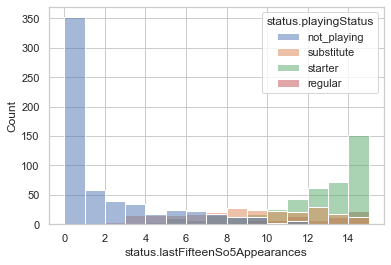

In [482]:
sns.histplot(data=df_player_scores_detailed,x='status.lastFifteenSo5Appearances',binwidth=1,hue='status.playingStatus');

Stats

In [513]:
stat_columns=player_detailed_gamescore['stat'].unique().tolist()
stat_columns.remove('level_score')
#stat_columns.remove('score')

Scale stats with min max scaler so that they can be compared. Visualize average stats by position to understand differences.

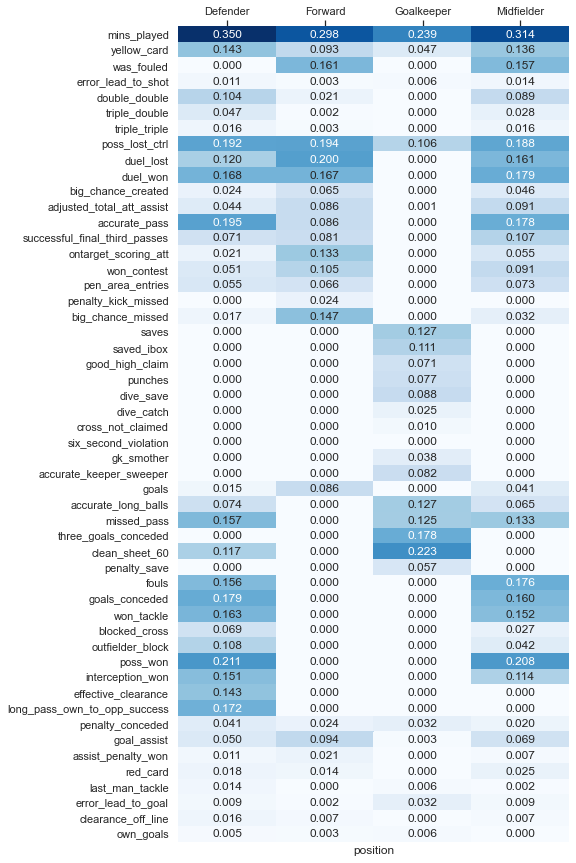

In [514]:
scaler_minmax=MinMaxScaler()
stats_scaled=scaler_minmax.fit_transform(df_player_scores_detailed[stat_columns])

df_stats_minmax=pd.DataFrame(data=stats_scaled,columns=stat_columns)
df_stats_minmax['position']=df_player_scores_detailed['position']

plt.figure(figsize=(7,15))
sns.heatmap(df_stats_minmax.groupby('position')[stat_columns].mean().T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


## Clustering

Identify different groups of players by making clusters with stats.

Keep only starter and regular players thar are not goalkeepers.

In [515]:
mask_starter=df_player_scores_detailed['status.playingStatus']=='starter'
mask_regular=df_player_scores_detailed['status.playingStatus']=='regular'
mask_not_goalkeeper=df_player_scores_detailed['position']!='Goalkeeper'
X=df_player_scores_detailed[(mask_starter|mask_regular)&(mask_not_goalkeeper)]
X=X[stat_columns]
print(X.shape)

(462, 52)


### PCA

Reducing dimensionality with PCA

In [516]:
#scale
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)

pca_df = PCA()
pca_df.fit(X_scaled)
pca_df.explained_variance_ratio_.round(2)

array([0.23, 0.12, 0.06, 0.05, 0.05, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

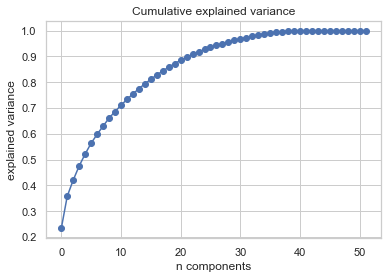

In [590]:
pd.Series(pca_df.explained_variance_ratio_).cumsum().plot.line(marker='o')
plt.title('Cumulative explained variance')
plt.xlabel('n components')
plt.ylabel('explained variance');

In [518]:
pca_loadings = pd.DataFrame(pca_df.components_.T, index=X.columns).iloc[:,:10]
pca_loadings.style.background_gradient(axis=None,cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9
mins_played,0.193179,0.292827,0.392224,0.117118,-0.120185,-0.091701,-0.022066,-0.075288,-0.030937,-0.050520
yellow_card,0.123324,0.075148,-0.335123,0.881670,0.147811,-0.138927,-0.013926,0.009226,-0.014512,-0.042490
was_fouled,-0.162526,0.375562,-0.226790,-0.044375,-0.219328,-0.135875,-0.124777,0.182255,-0.190985,0.099525
error_lead_to_shot,0.009658,-0.021106,-0.006572,0.020622,-0.018254,-0.042407,-0.031456,0.001815,-0.035304,-0.062749
double_double,0.195610,0.117250,-0.190143,-0.030967,-0.140276,0.201054,-0.478374,0.133960,0.118122,-0.508545
triple_double,0.078992,0.028050,-0.005482,-0.086811,0.016879,0.159160,-0.018525,-0.194482,-0.105657,0.216269
triple_triple,0.029810,0.031613,-0.045560,-0.013281,0.008902,0.036920,-0.210588,0.015633,-0.025999,0.313454
poss_lost_ctrl,0.039824,0.324290,0.161084,0.044039,0.045422,0.063173,0.114839,-0.203266,0.340774,-0.049808
duel_lost,-0.073703,0.237352,0.056879,0.073378,-0.097471,0.031591,-0.018470,-0.193749,0.027370,0.195119
duel_won,0.068055,0.296022,-0.003263,0.009010,-0.182926,0.116177,-0.281678,-0.064120,0.037769,0.117237


### Cluster

In [519]:
def Search_Kmeans(X_scaled):
    k_values=range(2,20)
    sq_distances=[] 
    sil=[]
    ch_scores=[]
    for k in k_values:
        kmeans=KMeans(n_clusters=k,n_init=10,random_state=0)
        kmeans.fit(X_scaled)
        sq_distances.append(kmeans.inertia_)
        score=silhouette_score(X_scaled,kmeans.labels_)
        sil.append(score)
        score=calinski_harabasz_score(X_scaled,kmeans.labels_)
        ch_scores.append(score)

    fig, axs = plt.subplots(1,3,figsize=(20,5))
    axs[0].set(xlabel = "Número de clusters", ylabel = "Suma Distancias Cuadráticas", title = "Inercia Score")
    axs[1].set(xlabel = "Número de clusters", ylabel = "Silhouette score", title = "Silhouette Score")
    axs[2].set(xlabel = "Número de clusters", ylabel = "Calinski-Harabasz Score", title = "Calinski-Harabasz Score")
    sns.lineplot(ax=axs[0],x=k_values,y=sq_distances,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[1],x=k_values,y=sil,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[2],x=k_values,y=ch_scores,marker='o',size=30,legend=False )
    axs[0].grid(color='gray', linewidth=1, ls='--')
    axs[1].grid(color='gray', linewidth=1, ls='--')
    axs[2].grid(color='gray', linewidth=1, ls='--')

In [520]:
X.shape

(462, 52)

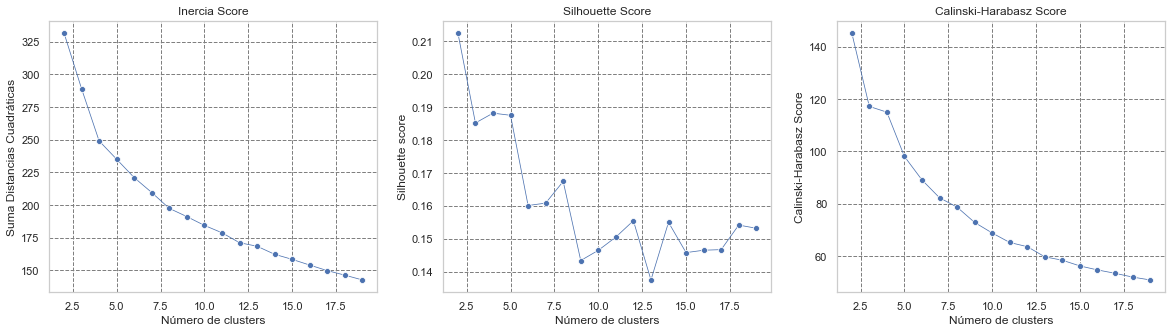

In [521]:
n_components=10
df_pca = pd.DataFrame(pca_df.transform(X_scaled)[:,:n_components], index=X.index)
df_pca.head(5)

Search_Kmeans(df_pca)

Generate 3 clusters, and calculate distance to each centroid

In [553]:
n_clusters=3
kmeans=KMeans(n_clusters=n_clusters,random_state=1)
kmeans.fit(df_pca)

df_output=df_player_scores_detailed.loc[X.index]
df_output['label']=kmeans.labels_

dist_clusters=kmeans.transform(df_pca)
df_dist_clusters=pd.DataFrame(index=df_pca.index,data=dist_clusters)
dist_col_names=['dist_cluster_'+str(i) for i in df_dist_clusters.columns]
df_output[dist_col_names]=df_dist_clusters


### Cluster Analysis

Visualize which positions are included in each cluster

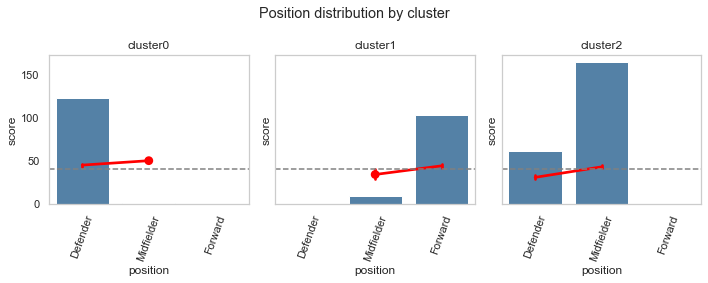

In [554]:

positions=['Defender','Midfielder','Forward']
labels=range(0,n_clusters)

n_plots=df_output['label'].nunique()
max_col=n_clusters
max_row=int(np.ceil(n_plots/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(10,4),squeeze=False,sharey=True)
for i in range(n_plots):
    df=df_output[df_output.label==i]
    ax_i=ax[n_row,n_col]
    sns.countplot(data=df,x='position',ax=ax_i,color='steelblue',order=positions)
    sns.pointplot(data=df,x='position',y='score',ax=ax_i,color='red',order=positions)
    ax_i.axhline(40, ls='--',color='gray')
    ax_i.set_xticklabels(ax_i.get_xticklabels(),rotation=70)

    ax_i.set_title('cluster'+str(i))
    ax_i.grid(False)
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.suptitle('Position distribution by cluster')
plt.tight_layout()

The clusters are mainly grouping by position. Something interesting is that there are players that seem to be "misclassified", for example defenders in the cluster with mostly midfielders, or midfielders in the cluster with mostly forwards. We will try to identify if these players have a playing style more similar than those in the other position and why.

Visualize how each position is distributed between clusters

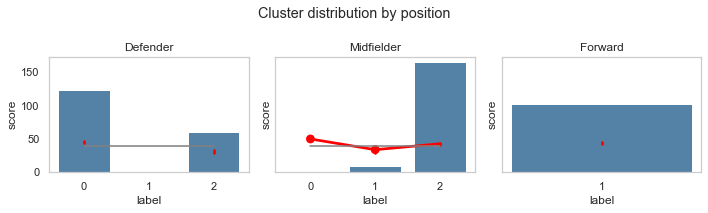

In [555]:
n_plots=df_output['label'].nunique()
max_col=3
max_row=int(np.ceil(len(positions)/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(10,3),squeeze=False,sharey=True)
for i in positions:
    df=df_output[df_output.position==i].copy()
    ax_i=ax[n_row,n_col]
    sns.countplot(data=df,x='label',ax=ax_i,color='steelblue',order=labels)
    sns.pointplot(data=df,x='label',y='score',ax=ax_i,color='red',order=labels)
    sns.lineplot(x=df.label,y=np.ones(df.label.shape[0])*40,ax=ax_i,color='gray')

    ax_i.set_title(str(i))
    ax_i.grid(False)
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.suptitle('Cluster distribution by position')
plt.tight_layout()


Give names to each cluster

In [557]:
df_output['label_name']=df_output.label.map({1:'Offensive',0:'Defensive',2:'Mid'})

df_output.rename(columns={
    'dist_cluster_1':'dist_offensive',
    'dist_cluster_0':'dist_defensive',
    'dist_cluster_2':'dist_midfielder',
},inplace=True)

dist_col_names=['dist_midfielder',
    'dist_offensive','dist_defensive']

In [558]:
df_output['label_name'].value_counts()

Mid          226
Defensive    124
Offensive    112
Name: label_name, dtype: int64

Scale stats so that they can be compared, and visualize how stat values are distributed between clusters.

In [563]:
cluster_stats=df_output.groupby('label_name')[stat_columns].mean()
cluster_stats

,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,duel_won,...,effective_clearance,long_pass_own_to_opp_success,penalty_conceded,goal_assist,assist_penalty_won,red_card,last_man_tackle,error_lead_to_goal,clearance_off_line,own_goals
label_name,,,,,,,,,,,,,,,,,,,,,
Defensive,79.117742,0.190323,0.008065,0.012903,0.212903,0.038710,0.008065,10.120968,2.953226,3.840323,...,2.735484,4.622581,0.088710,0.201613,0.016129,0.040323,0.024194,0.032258,0.040323,0.016129
Mid,62.076991,0.160177,0.730973,0.007965,0.160177,0.027434,0.006195,9.077876,3.428319,3.686726,...,0.302655,0.549558,0.035398,0.265487,0.022124,0.030973,0.008850,0.030973,0.013274,0.000000
Offensive,62.448214,0.108929,1.014286,0.003571,0.037500,0.000000,0.001786,9.733929,4.707143,3.587500,...,0.000000,0.000000,0.062500,0.435268,0.044643,0.026786,0.000000,0.008929,0.008929,0.008929


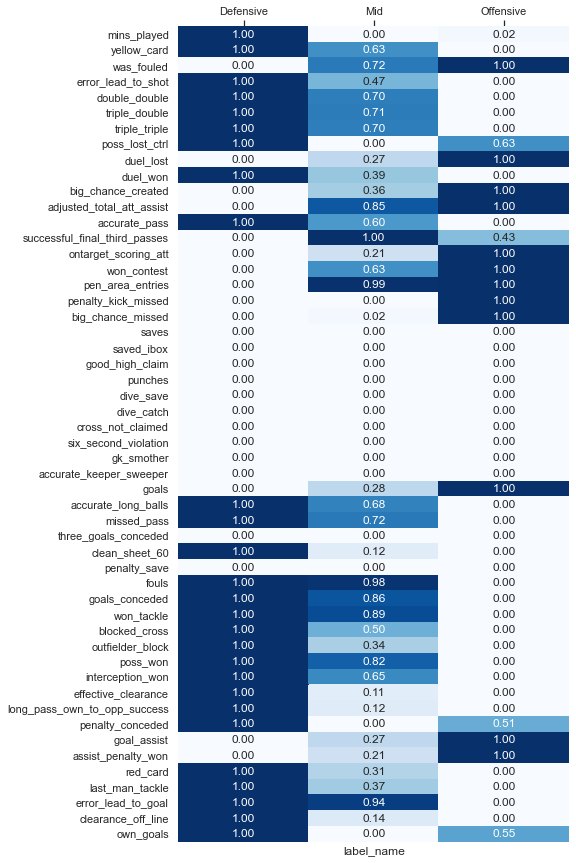

In [564]:
scaler=MinMaxScaler()
cluster_scaled=scaler.fit_transform(cluster_stats)

df_cluster_scaled=pd.DataFrame(data=cluster_scaled,columns=stat_columns,index=cluster_stats.index)

plt.figure(figsize=(7,15))
sns.heatmap(df_cluster_scaled.T,annot=True,cbar=False,fmt='.2f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


Visualize how each PCA component is included in each cluster

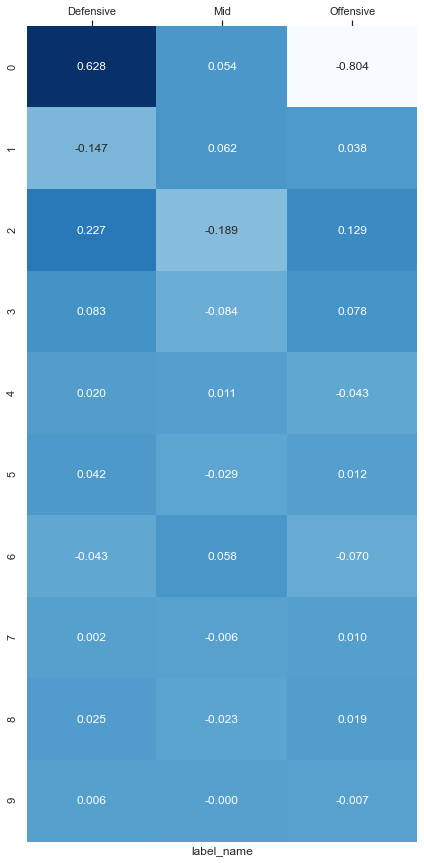

In [565]:
output_pca=df_pca.copy()
output_pca['label_name']=df_output['label_name']
cluster_pca=output_pca.groupby('label_name').mean()

plt.figure(figsize=(7,15))
sns.heatmap(cluster_pca.T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')

Check how players in best known clubs (Barcelona, Atletico de Madrid and Real Madrid) are being classified.

In [566]:
col_names=['label_name','slug_player','score','position','slug_club','mins_played','dist_midfielder','dist_offensive','dist_defensive']
df_output_dists=df_output[col_names].sort_values(by='label_name')
df_output_dists[df_output_dists.slug_club.isin(['psg-paris','real-madrid-madrid','atletico-madrid-madrid','barcelona-barcelona'])][col_names].sort_values(by='label_name')

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_defensive
566,Defensive,ronald-federico-araujo-da-silva,34.100000,Defender,barcelona-barcelona,63.0,0.798211,1.276674,0.635353
693,Defensive,reinildo-isnard-mandava,42.280000,Defender,atletico-madrid-madrid,87.6,1.038505,1.712629,0.527513
61,Defensive,eder-gabriel-militao,57.507282,Defender,real-madrid-madrid,90.0,1.391058,1.875242,0.883271
64,Defensive,daniel-carvajal-ramos,59.881068,Defender,real-madrid-madrid,85.6,1.522315,1.906498,1.264823
684,Defensive,jose-maria-gimenez-de-vargas,32.440000,Defender,atletico-madrid-madrid,63.0,0.906889,1.213340,0.848216
681,Defensive,sime-vrsaljko,41.360000,Defender,atletico-madrid-madrid,62.2,1.064444,1.614849,0.944803
41,Defensive,david-olatukunbo-alaba,47.720000,Defender,real-madrid-madrid,72.0,1.065649,1.376571,0.833782
1162,Defensive,marcos-aoas-correa,55.020000,Defender,psg-paris,90.0,1.246632,1.647586,0.768819
1154,Defensive,presnel-kimpembe,63.461165,Defender,psg-paris,87.6,1.213074,1.589019,0.771777
595,Defensive,gerard-pique-bernabeu,51.283575,Defender,barcelona-barcelona,71.8,1.174434,1.760357,0.841533


Check players with biggest distance from all clusters. These are the most dis-similar players

In [567]:
df_output_dists['min_dist']=df_output_dists[dist_col_names].apply(min,axis=1)
mask_max=df_output_dists['min_dist']>df_output_dists['min_dist'].quantile(0.95)
df_output_dists[mask_max].sort_values(by='min_dist',ascending=False)

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_defensive,min_dist
1168,Offensive,lionel-andres-messi-cuccittini,83.138065,Forward,psg-paris,90.0,2.247714,1.826304,2.535636,1.826304
1109,Mid,vincent-pajot,44.954822,Midfielder,metz-metz,85.2,1.567845,2.111881,1.657978,1.567845
713,Mid,sofiane-boufal,51.891371,Midfielder,angers-sco-angers,85.0,1.504061,1.703430,1.896064,1.504061
168,Defensive,marcos-javier-acuna,31.927184,Defender,sevilla-sevilla-1890,68.8,1.479912,1.759442,1.464542,1.464542
645,Mid,franco-emanuel-cervi,64.321320,Midfielder,celta-de-vigo-vigo,70.0,1.444046,1.823416,1.688480,1.444046
698,Mid,geoffrey-kondogbia,63.626531,Midfielder,atletico-madrid-madrid,68.0,1.436299,1.921328,1.604715,1.436299
250,Mid,serge-aurier,27.949275,Defender,villarreal-villarreal,36.2,1.426844,1.538974,1.545251,1.426844
802,Mid,dimitri-payet,59.204040,Midfielder,olympique-marseille-marseille,72.2,1.426336,1.462636,1.755756,1.426336
1161,Mid,marco-verratti,55.018878,Midfielder,psg-paris,72.0,1.420355,1.890955,1.628247,1.420355
915,Defensive,facundo-axel-medina,54.371498,Defender,lens-avion,88.6,1.854770,2.436701,1.403185,1.403185


Using distance to each cluster as a proxy for similarity with a position, we can visualize how each player's playing style resembles the one of defenders, midfielders and forwards. We can also understand which players are more different than everyone else by looking at players with larger distances to cluster centroids. For example Lionel Messi is one of the players most separeted from the rest. This means that his stats are far away from the others.

In [594]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_defensive',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Offensive and defensive similarity')

In [569]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_midfielder',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Midfielder and offensive similarity')

In [570]:
metric='accurate_pass'
df_player_scores_detailed.sort_values(by=metric,ascending=False)[['slug_club','slug_player','position','score',metric]].head(20)

,slug_club,slug_player,position,score,accurate_pass
1161,psg-paris,marco-verratti,Midfielder,55.018878,72.4
63,real-madrid-madrid,toni-kroos,Midfielder,50.700000,70.0
900,olympique-lyonnais-lyon,castello-lukeba,Defender,51.140000,69.8
883,olympique-lyonnais-lyon,thiago-henrique-mendes-ribeiro,Midfielder,51.692857,69.4
915,lens-avion,facundo-axel-medina,Defender,54.371498,66.6
1154,psg-paris,presnel-kimpembe,Defender,63.461165,65.6
595,barcelona-barcelona,gerard-pique-bernabeu,Defender,51.283575,65.2
761,nantes-la-chapelle-sur-erdre,pedro-chirivella-burgos,Midfielder,60.005102,64.4
1162,psg-paris,marcos-aoas-correa,Defender,55.020000,63.0
1196,nice-nice,dante-bonfim-da-costa-santos,Defender,51.627670,62.4


### What makes each player unique?

For each player we look at the stats more different from it's cluster center. These are the aspects in which the player mostly stands out.

In [571]:
df_player_stats_scaled=pd.DataFrame(index=X.index,columns=X.columns,data=X_scaled)
df_player_stats_scaled=df_player_stats_scaled.join(df_output[['slug_club','slug_player','label_name','position','score']],how='left')

In [572]:
def calc_player_vs_cluster(player_slug:str,cluster:str,player_name=None):
    cluster_mean=df_player_stats_scaled[df_player_stats_scaled['label_name']==cluster].mean(numeric_only=True)
    player_mean=df_player_stats_scaled[df_player_stats_scaled['slug_player']==player_slug].mean(numeric_only=True)
    cluster_name=cluster+'_cluster'
    if player_name==None:
        player_name=player_slug
    player_vs_cluster=pd.DataFrame(data={player_name:player_mean,cluster_name:cluster_mean}).reset_index().rename(columns={'index':'stat'})
    player_vs_cluster.head()
    player_vs_cluster['dif']=player_vs_cluster[player_name]-player_vs_cluster[cluster_name]
    player_vs_cluster['abs_dif']=abs(player_vs_cluster['dif'])
    player_vs_cluster.sort_values(by='abs_dif',ascending=False,inplace=True)
    player_vs_cluster.drop(index=player_vs_cluster[player_vs_cluster['stat']=='score'].index,inplace=True)#drop score
    return player_vs_cluster

In [573]:
def plot_player_vs_cluster(player_vs_cluster_df:pd.DataFrame,ax=None):
       player_vs_cluster_df=player_vs_cluster_df.head(10)
       ax.hlines(y=player_vs_cluster_df['stat'], xmin=player_vs_cluster_df[player_vs_cluster_df.columns[2]], xmax=player_vs_cluster_df[player_vs_cluster_df.columns[1]],
           color='#d9d9d9', lw=10)
       sns.scatterplot(data=player_vs_cluster_df,x=player_vs_cluster_df.columns[1],
       y='stat',label=player_vs_cluster_df.columns[1],zorder=3,s=200,color='#0096d7',ax=ax)
       sns.scatterplot(data=player_vs_cluster_df,x=player_vs_cluster_df.columns[2],
       y='stat',label=player_vs_cluster_df.columns[2],zorder=3,s=200,color='#003953',ax=ax);
       
       ax.set_xlabel('')
       ax.set_ylabel('')
       ax.set_xlim(-0.01,1.01)
       ax.set_title(player_vs_cluster_df.columns[1]+'`s Top 10 most different stats',loc='left')
       ax.legend(ncol=2, bbox_to_anchor=(1., -0.2), loc="lower right", frameon=False)



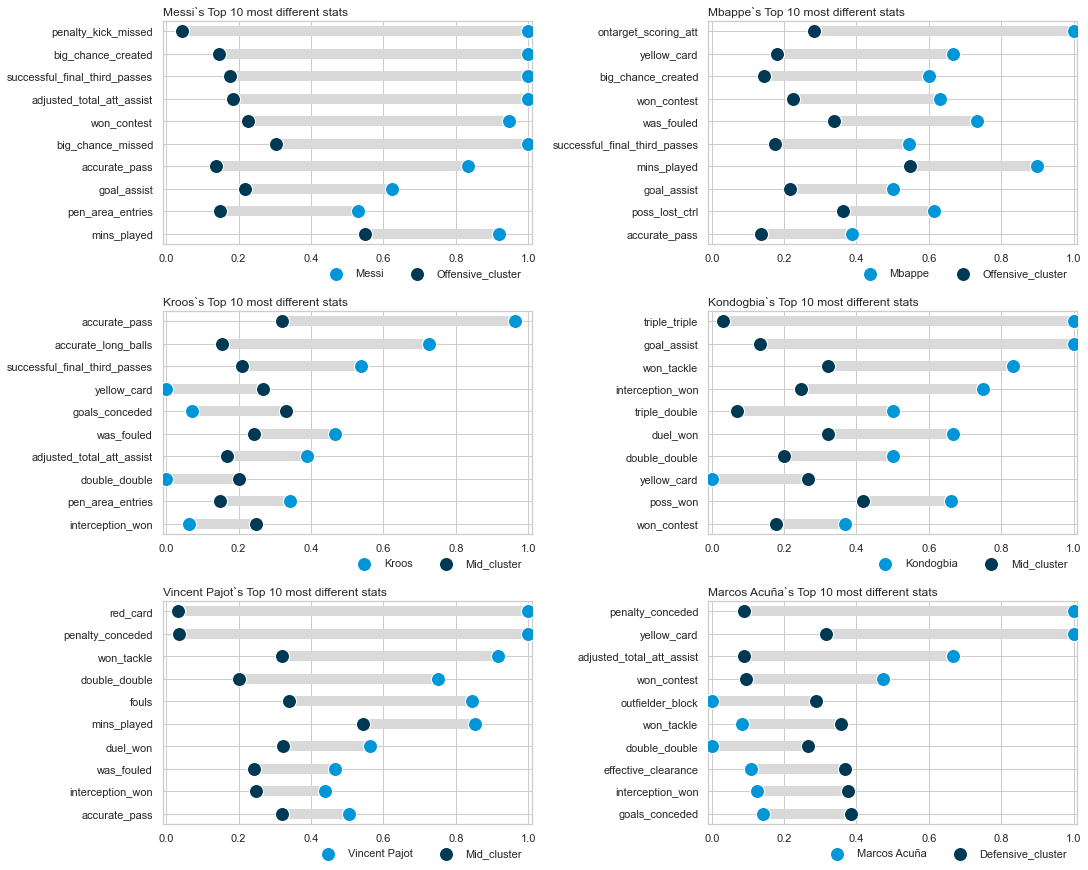

In [596]:

player_names=['Messi','Mbappe','Kroos','Kondogbia','Vincent Pajot','Marcos Acuña']
player_slugs=['lionel-andres-messi-cuccittini','kylian-mbappe-lottin','toni-kroos','geoffrey-kondogbia','vincent-pajot','marcos-javier-acuna']
clusters=['Offensive','Offensive','Mid','Mid','Mid','Defensive']

n_subplots=len(player_names)
cols=2
rows=int(np.ceil(n_subplots/cols))
fig,ax=plt.subplots(rows,cols,figsize=(15,rows*4),constrained_layout=True)

row=0
col=0
for player_slug,player_name,cluster in zip(player_slugs,player_names,clusters):
    player_vs_cluster=calc_player_vs_cluster(player_slug,cluster,player_name)
    ax_i=ax[row,col]
    plot_player_vs_cluster(player_vs_cluster,ax=ax_i)
    col+=1
    if col==cols:
        col=0
        row+=1